In [1]:
import os
import csv
import numpy as np
import pandas as pd
import multiprocessing
from time import perf_counter
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    permutation_test_score, cross_validate
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm
from collections import Counter
import json
import warnings
import re 
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [4]:
import sklearn
from sklearn.preprocessing import OneHotEncoder as _OneHotEncoder

# Wrapper de compatibilité par composition
class OneHotEncoderCompat:
    def __init__(self, *args, **kwargs):
        if "sparse" in kwargs and "sparse_output" not in kwargs:
            kwargs["sparse_output"] = kwargs.pop("sparse")
        self._enc = _OneHotEncoder(*args, **kwargs)

    def fit(self, X, y=None):
        return self._enc.fit(X, y)

    def transform(self, X):
        return self._enc.transform(X)

    def fit_transform(self, X, y=None):
        return self._enc.fit_transform(X, y)

    def get_feature_names_out(self, *args, **kwargs):
        return self._enc.get_feature_names_out(*args, **kwargs)

    def __getattr__(self, name):
        return getattr(self._enc, name)

import neurocombat_sklearn
neurocombat_sklearn.neurocombat_sklearn.OneHotEncoder = OneHotEncoderCompat
from neurocombat_sklearn import CombatModel

import neurocombat_sklearn.neurocombat_sklearn as ncs

print("OneHotEncoder patché ? ->", ncs.OneHotEncoder)



OneHotEncoder patché ? -> <class '__main__.OneHotEncoderCompat'>


In [5]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv"
base_path  = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"
output_csv  = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_prematurity_results_final_28_32_corrected.csv"
thresholds  = ["28-32"]

In [6]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [7]:
def load_embeddings(region):
    
    for file in os.listdir(base_path):
            if file.startswith(region) and file.endswith(".csv"):
                embedding_file = file
                break
            
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")

    print(f"Using embedding file: {embedding_file}")

    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )
    return emb_df
    

In [8]:
def define_sex_class_mapping(sex_series):


    unique_sex = sorted(sex_series.unique())

    #print("unique sites :", unique_sex)

    mapping = {1.0: 0, 2.0:1, 3.0 : 1}
    
    def encoder_fn(site):
        return mapping[site]
    
    return mapping, encoder_fn

def define_scan_age_mapping(scan_ages_series): 


    unique_scan_ages = sorted(scan_ages_series.unique())



    scaler = StandardScaler()
    scan_ages =np.array(scan_ages_series).reshape(-1 ,1)
    scaler.fit(scan_ages)
    #print("unique_scan_ages :",unique_scan_ages)

    def encoder_fn(scan_age):
        return scaler.transform(np.array([[scan_age]])).item()

    
    return scaler, encoder_fn

In [9]:
def set_confound_df(label_counfounds_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv",income_df_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/income.csv"):
    
    counfounds_df = pd.read_csv(label_counfounds_path)
    counfounds_df = pd.get_dummies(counfounds_df,columns = ['site_id_l'],prefix='',prefix_sep='',drop_first=True)
    income_df = pd.read_csv(income_df_path)
    income_df['src_subject_id_clean'] = income_df['src_subject_id'].str.replace("_","")
    #keep only necessary columns
    income_df = income_df[['src_subject_id_clean','income_continuous','missing_income']]


    mapping, encode_site = define_sex_class_mapping(counfounds_df['demo_sex_v2'])
    counfounds_df['sex'] = counfounds_df['demo_sex_v2'].apply(encode_site)
    counfounds_df.drop(columns=['demo_sex_v2'],inplace=True)


    counfounds_df["interview_age"].fillna(115,inplace =True)

    scaler, encode_scan_age = define_scan_age_mapping(counfounds_df["interview_age"])

    counfounds_df['scan_age']= counfounds_df['interview_age'].apply(encode_scan_age)

    counfounds_df = counfounds_df.merge(income_df,left_on='src_subject_id_clean',how='left',right_on='src_subject_id_clean')


    # Filter to keep only necessary columns
    columns_to_keep = ['scan_age','sex','src_subject_id_clean','income_continuous','missing_income'] + [col for col in counfounds_df.columns if col.startswith('site')]
    counfounds_df = counfounds_df[columns_to_keep]

    #print("counfounds_df columns :",counfounds_df.columns) 

    return counfounds_df


set_confound_df()


/tmp/ipykernel_340414/679597559.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_340414/679597559.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


,scan_age,sex,src_subject_id_clean,income_continuous,missing_income,site02,site03,site04,site05,site06,...,site13,site14,site15,site16,site17,site18,site19,site20,site21,site22
0,1.608618,1,NDARINV003RTV85,8.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.939494,0,NDARINV007W6H7B,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-0.934053,0,NDARINV00BD7VDC,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.671845,0,NDARINV00HEV6HB,8.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.201702,0,NDARINV00J52GPG,6.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,-1.201702,1,NDARINVZZLZCKAY,9.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9981,-0.800228,1,NDARINVZZPKBDAC,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9982,0.270370,1,NDARINVZZZ2ALR6,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9983,-1.469352,1,NDARINVZZZNB0XC,3.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
def _is_categorical(series, max_unique_for_cat=10):
    """if dtype is object or has few unique values, treat as categorical."""
    if series.dtype == object:
        return True
    if pd.api.types.is_integer_dtype(series) and series.nunique() <= max_unique_for_cat:
        return True
    return False

def _bin_continuous_for_strat(series, n_bins):
    """Returns a series of categories in quantiles; if qcut fails, falls back to cut."""
    try:
        b = pd.qcut(series, q=n_bins, duplicates='drop')
    except Exception:
        b = pd.cut(series, bins=n_bins, duplicates='drop')
    # transformer en string simple
    b = b.astype(str)
    # remplacer 'nan' par 'missing' si des NA
    b = b.fillna('missing')
    return b

In [11]:
def prepare_cv_data(
    embeddings_df,
    labels_df,
    confounds_df,
    id_emb_col='ID_clean',
    id_label_col='src_subject_id',
    id_conf_col='src_subject_id_clean',
    confounds_for_strat=[],
    confounds_for_resid=None,
    threshold="28-32",
    dim_regex=r'^dim',
    n_splits=5,
    init_n_bins=5,
    max_unique_for_cat=10,
):
    """
    Prepares and merges everything for cross-validation, returns:
      merged_df          : dataframe (aligned) containing dims, labels, confounds
      X_all              : numpy array of dims
      y_all              : numpy array of binary labels
      ids_all            : array of ids (src_subject_id)
      stratify_labels    : array of combined labels (to pass to StratifiedKFold.split(..., stratify_labels))
      confounds_resid_df : dataframe of encoded confounds (for residualization)
    
    Important parameters:
      confounds_for_strat  : list of columns to use for stratification (can include numeric columns)
      confounds_for_resid  : list of columns to use for residualization (must match those in confounds_df)
      onehot_site          : if True, one-hot encode the site column (drop_first=True) in confounds_resid_df
    """
    # Copy all three datasets
    emb = embeddings_df.copy()
    lab = labels_df.copy()
    cf = confounds_df.copy()

    # make ids comparable
    emb[id_emb_col] = emb[id_emb_col].astype(str)
    lab[id_label_col] = lab[id_label_col].astype(str)
    cf[id_conf_col]  = cf[id_conf_col].astype(str)


    # Merge emb + prematurity labels + confounds
    merged = emb.merge(lab, left_on=id_emb_col, right_on=id_label_col, how='inner')
    df = merged.merge(cf, left_on=id_emb_col, right_on=id_conf_col, how='inner', suffixes=('','_cf'))

    # set y
    df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
    df['y'] = (df['prem_class'] == threshold).astype(int)
    
    # prepare X, y, ids
    X_all_df = df.filter(regex=dim_regex)
    X_all = X_all_df.values
    y_all = df['y'].values.astype(int)
    ids_all = df[id_label_col].astype(str).values

    # -confounds for resid
    if confounds_for_resid is None:
        confounds_for_resid = confounds_df.columns.tolist()
        confounds_for_resid.remove(id_conf_col)

    confounds_resid_df = confounds_df
    confounds_for_strat = confounds_for_resid.copy()


    # building the stratification labels
    if confounds_for_strat is None or len(confounds_for_strat) == 0:
        stratify_labels = y_all.astype(str)

    else:
        # columns copy from merged df
        strat_df = df[[id_label_col] + confounds_for_strat].copy()
        strat_df.set_index(id_label_col, inplace=True)
        # define the number of bins for continuous vars
        n_bins = init_n_bins
        while True:
            strat_cat_parts = []
            for c in confounds_for_strat:
                s = strat_df[c]
                if _is_categorical(s, max_unique_for_cat=max_unique_for_cat):
                    # str
                    part = s.astype(str).fillna('missing')
                else:
                    # continuous to bin
                    part = _bin_continuous_for_strat(s.fillna(s.median()), n_bins)
                strat_cat_parts.append(part.astype(str))
            # concatenate all parts with '|'
            strat_comb = strat_cat_parts[0].astype(str)
            for p in strat_cat_parts[1:]:
                strat_comb = strat_comb + '|' + p.astype(str)
            # add the label at the beginning to also strat on prematurity
            strat_comb = df['y'].astype(str).values + '||' + strat_comb.values

            # count min occurrences of any strata
            counts = pd.Series(strat_comb).value_counts()
            min_count = counts.min()
            if min_count >= n_splits:
                stratify_labels = strat_comb
                break
            else:
                # reduce n_bins and retry
                if n_bins > 2:
                    n_bins = max(2, n_bins - 1)
                    # print debug info
                    #print(f"[prepare_cv_data] strata trop rares (min={min_count}), réduction bins -> {n_bins}")
                    continue
                else:
                    # if nothing works, fallback to y only
                    #print("[prepare_cv_data] impossible d'obtenir strata valides, fallback à stratification sur y seulement.")
                    stratify_labels = df['y'].astype(str).values
                    break

    # final return
    return {
        'df_complete': df,                    # contains dims, labels, and confounds 
        'X_all_df': X_all_df,                   # DataFrame of dims
        'X_all': X_all,                         # numpy array dims
        'y_all': y_all,
        'ids_all': ids_all,
        'stratify_labels': np.array(stratify_labels, dtype=str),
        'confounds_resid_df': confounds_resid_df # DataFrame of confounds for resid
    }

In [12]:
def residualize_in_folds_from_prep(
    prep,
    confounds_list=None,
    id_label_col='src_subject_id',   # column id in prep['df_complete']
    id_emb_col='ID_clean',           # column id in the embeddings (prep['df_complete'])
    dim_regex=r'^dim',
    n_splits=5,
    random_state=42,
    use_statsmodels=True
):
    """
    Input:
    - prep: dict returned by prepare_cv_data(...)
    - confounds_list: list of column names (in prep['df_complete']) to use as covariates.
                        If None, it will be inferred from prep['confounds_resid_df']
                        (all columns except the ID column).
    - id_label_col / id_emb_col: column names of subject IDs in prep['df_complete'] (strings).
    - dim_regex: regex pattern used to select embedding columns.
    - n_splits: number of outer folds (must match the value used to build stratify_labels).
    - use_statsmodels: if True, perform OLS residualization dimension-by-dimension using statsmodels (slower).

    Output:
    - folds_residualized: list of dicts (one per outer fold), each containing:
        {
            'X_train_resid': np.array of shape (n_train, n_dims),
            'X_test_resid' : np.array of shape (n_test, n_dims),
            'y_train': np.array of shape (n_train,),
            'y_test' : np.array of shape (n_test,),
            'train_ids': list of subject IDs for training,
            'test_ids' : list of subject IDs for testing,
        }
    """

    # extraire infos from prep
    merged_df = prep['df_complete']            # df contains dims, y, confounds
    X_all = prep['X_all']
    y_all = prep['y_all']
    ids_all = prep['ids_all']
    stratify_labels = prep['stratify_labels']
    confounds_df = prep['confounds_resid_df']  #  just in case

    # get confound list if not provided
    if confounds_list is None:
        candidate = list(confounds_df.columns)
        # exclude id col
        candidate = [c for c in candidate if not any(tok in c.lower() for tok in ('src', 'id'))]
        confounds_list = candidate

    #print(f"[residualize_in_folds_from_prep] using confounds: {confounds_list}")

    # sanity check : confounds exist in merged_df
    missing = [c for c in confounds_list if c not in merged_df.columns]
    if len(missing) > 0:
        raise ValueError(f"Confounds {missing} not found in merged_df columns. Adjust confounds_list or check prep.")

    # get embeddings columns
    X_df = merged_df.filter(regex=dim_regex)
    dim_cols = X_df.columns.tolist()
    n_dims = len(dim_cols)

    # build outer CV using stratify_labels fournis by prep
    outer = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds_residualized = []

    for fold_i, (train_idx, test_idx) in enumerate(outer.split(X_all, stratify_labels)):
        # ids corresponding to train/test idx
        train_ids = ids_all[train_idx]
        test_ids  = ids_all[test_idx]

        # sélectionner lignes correspondantes dans merged_df via id_emb_col
        # merged_df may contain ids as strings; ensure consistent dtype
        merged_df[id_emb_col] = merged_df[id_emb_col].astype(str)
        train_mask = merged_df[id_emb_col].isin([str(x) for x in train_ids])
        test_mask  = merged_df[id_emb_col].isin([str(x) for x in test_ids])

        X_train_emb_df = merged_df.loc[train_mask, dim_cols].astype(float)
        X_test_emb_df  = merged_df.loc[test_mask,  dim_cols].astype(float)
        conf_train_df  = merged_df.loc[train_mask, confounds_list].astype(float)
        conf_test_df   = merged_df.loc[test_mask,  confounds_list].astype(float)

        # checks (si certains ids n'existent pas dans merged_df ils sont automatiquement exclus)
        if X_train_emb_df.shape[0] == 0:
            raise ValueError(f"Fold {fold_i}: no train samples after matching ids.")
        if X_test_emb_df.shape[0] == 0:
            raise ValueError(f"Fold {fold_i}: no test samples after matching ids.")

        # perform residualization
        if use_statsmodels:
            # slow: OLS per-dimension
            # add constant
            X_conf_train = sm.add_constant(conf_train_df, has_constant='add')
            X_conf_test  = sm.add_constant(conf_test_df, has_constant='add')

            resid_train_df = pd.DataFrame(index=X_train_emb_df.index, columns=dim_cols, dtype=float)
            resid_test_df  = pd.DataFrame(index=X_test_emb_df.index,  columns=dim_cols, dtype=float) # je crois que les deux sont équivalents

            for col in dim_cols:
                y_tr_col = X_train_emb_df[col]
                ols = sm.OLS(y_tr_col, X_conf_train).fit()
                pred_tr = ols.predict(X_conf_train)
                pred_te = ols.predict(X_conf_test)
                resid_train_df[col] = y_tr_col - pred_tr
                resid_test_df[col]  = X_test_emb_df[col] - pred_te

        else:
            # fast: sklearn LinearRegression multi-output
            lr = LinearRegression()
            lr.fit(conf_train_df.values, X_train_emb_df.values)  # multi-output fit
            pred_train = lr.predict(conf_train_df.values)
            pred_test  = lr.predict(conf_test_df.values)

            resid_train_df = pd.DataFrame(pred_train, index=X_train_emb_df.index, columns=dim_cols)
            resid_test_df  = pd.DataFrame(pred_test,  index=X_test_emb_df.index,  columns=dim_cols)
            resid_train_df = X_train_emb_df.values - resid_train_df.values
            resid_test_df  = X_test_emb_df.values  - resid_test_df.values
            # wrap back to DataFrame with proper index/cols
            resid_train_df = pd.DataFrame(resid_train_df, index=X_train_emb_df.index, columns=dim_cols)
            resid_test_df  = pd.DataFrame(resid_test_df,  index=X_test_emb_df.index,  columns=dim_cols)

        # collect y aligned with the rows we will return
        # y_all is aligned with ids_all; train_idx/test_idx correspond to ids_all positions
        # but some ids could have been dropped if they were missing in merged_df; we must pick y by id.
        id_to_y = dict(zip(ids_all.astype(str), y_all.astype(int)))
        train_ids_present = merged_df.loc[train_mask, id_emb_col].astype(str).tolist()
        test_ids_present  = merged_df.loc[test_mask, id_emb_col].astype(str).tolist()

        

        y_train = np.array([id_to_y[i] for i in train_ids_present], dtype=int)
        y_test  = np.array([id_to_y[i] for i in test_ids_present], dtype=int)



        folds_residualized.append({
            'X_train_resid': resid_train_df.values,
            'X_test_resid' : resid_test_df.values,
            'y_train': y_train,
            'y_test' : y_test,
            'train_ids': train_ids_present,
            'test_ids' : test_ids_present
        })

    # Still add the entire data residualized for further analysis
    
    # This is not fold-specific, just for reference
    full_conf_df = merged_df[confounds_list].astype(float)
    lr_full = LinearRegression()
    lr_full.fit(full_conf_df.values, X_df.values)
    pred_full = lr_full.predict(full_conf_df.values)
    resid_full = X_df.values - pred_full
    merged_df_resid = merged_df.copy()
    merged_df_resid[dim_cols] = resid_full
    folds_residualized.append({
        'X_all_resid': merged_df_resid.filter(regex=dim_regex).values,
        'y_all': y_all,
        'ids_all': ids_all
    })


    return folds_residualized


In [13]:
def classify_with_resid(
    folds_residualized,
    n_jobs=-1,
    n_permutations=1000,
    perm_seed=0,
    alpha=0.05,
    grid_C = [10**k for k in range(-3,4)],
    inner_cv_splits=5,
    random_state_tuning=0,
):
    """
    - Tuning (léger leak assumé) : GridSearchCV sur l'entrée 'full' résidualisée (X_all_resid, y_all).
    - Éval OOF : pour chaque fold, fit sur X_train_resid/y_train, prédire sur X_test_resid, calcule AUC.
    - Permutation test : on permute y_all (mêmes ids), puis on ré-exécute exactement le même schéma de folds
      en reprenant les matrices résidualisées par fold (aucune ré-estimation de résidualisation/ComBat).
    """

    # -------- (A) Récupération de l’entrée "full" (pour tuning uniquement) --------
    full = next(e for e in folds_residualized[::-1] if 'X_all_resid' in e)
    X_all_resid = full['X_all_resid']
    y_all       = np.asarray(full['y_all']).astype(int)
    ids_all     = np.asarray(full['ids_all']).astype(str)

    # gardes-fous
    keep = ~np.isnan(y_all)
    X_all_resid = X_all_resid[keep]
    y_all = y_all[keep]
    ids_all = ids_all[keep]

    # -------- (B) Tuning global (léger leak assumé) --------
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            solver='lbfgs', penalty='l2',
            max_iter=1000, class_weight='balanced', random_state=0))
    ])
    # si binaire: utiliser StratifiedKFold; sinon KFold
    if len(np.unique(y_all)) == 2:
        inner_cv = StratifiedKFold(n_splits=min(inner_cv_splits, np.sum(keep)), shuffle=True, random_state=random_state_tuning)
        scoring = 'roc_auc'
    else:
        inner_cv = KFold(n_splits=min(inner_cv_splits, np.sum(keep)), shuffle=True, random_state=random_state_tuning)
        scoring = 'roc_auc_ovr_weighted'

    grid = GridSearchCV(
        pipe,
        {'clf__C': grid_C},
        cv=inner_cv,
        scoring=scoring,
        refit=True,
        n_jobs=n_jobs
    )
    grid.fit(X_all_resid, y_all)
    C_fixed = float(grid.best_params_.get('clf__C', 1.0))

    # -------- (C) Évaluation OOF sur folds résidualisés (zéro fuite de résidualisation) --------
    # mapping id -> y pour reconstruire y par fold
    id2y = dict(zip(ids_all, y_all))

    auc_per_fold = []
    oof_scores = []  # scores continus
    oof_true   = []

    for f in folds_residualized:
        if 'X_train_resid' not in f:
            continue

        Xtr = f['X_train_resid']
        Xte = f['X_test_resid']
        ytr = np.array([id2y[i] for i in f['train_ids']], dtype=int)
        yte = np.array([id2y[i] for i in f['test_ids']], dtype=int)

        # drop NaN (au cas où)
        keep_tr = ~np.isnan(ytr)
        keep_te = ~np.isnan(yte)
        Xtr, ytr = Xtr[keep_tr], ytr[keep_tr]
        Xte, yte = Xte[keep_te], yte[keep_te]
        if len(ytr) < 2 or len(yte) < 1 or len(np.unique(ytr)) < 2 or len(np.unique(yte)) < 2:
            # impossible de calculer une AUC si le test est mono-classe
            continue

        model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                solver='lbfgs', penalty='l2',
                C=C_fixed,
                max_iter=1000, class_weight='balanced', random_state=0))
        ])
        model.fit(Xtr, ytr)

        # scores continus pour AUC
        if hasattr(model.named_steps['clf'], "predict_proba"):
            s_test = model.predict_proba(Xte)[:, 1]
        else:
            s_test = model.decision_function(Xte)

        fold_auc = roc_auc_score(yte, s_test)
        auc_per_fold.append(fold_auc)

        oof_scores.append(s_test)
        oof_true.append(yte)

    if len(oof_true) == 0:
        raise RuntimeError("Aucun fold valide (p.ex. test mono-classe).")

    oof_scores = np.concatenate(oof_scores)
    oof_true   = np.concatenate(oof_true)

    auc_mean = float(np.mean(auc_per_fold))
    auc_std  = float(np.std(auc_per_fold))
    auc_obs  = float(roc_auc_score(oof_true, oof_scores))

    # -------- (D) Permutation test qui respecte les folds --------
    rng = np.random.default_rng(perm_seed)
    perm_scores = np.empty(n_permutations, dtype=float)

    for p in range(n_permutations):
        # permuter les labels globaux puis re-projeter par id sur chaque fold
        y_perm_all = rng.permutation(y_all)
        id2y_perm = dict(zip(ids_all, y_perm_all))

        perm_oof_scores = []
        perm_oof_true   = []

        for f in folds_residualized:
            if 'X_train_resid' not in f:
                continue
            Xtr = f['X_train_resid']
            Xte = f['X_test_resid']
            ytr = np.array([id2y_perm[i] for i in f['train_ids']], dtype=int)
            yte = np.array([id2y_perm[i] for i in f['test_ids']], dtype=int)

            keep_tr = ~np.isnan(ytr)
            keep_te = ~np.isnan(yte)
            Xtr, ytr = Xtr[keep_tr], ytr[keep_tr]
            Xte, yte = Xte[keep_te], yte[keep_te]
            # skip si train/test mono-classe
            if len(ytr) < 2 or len(yte) < 1 or len(np.unique(ytr)) < 2 or len(np.unique(yte)) < 2:
                continue

            model = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(
                    solver='lbfgs', penalty='l2',
                    C=C_fixed,
                    max_iter=1000, class_weight='balanced', random_state=0))
            ])
            model.fit(Xtr, ytr)

            if hasattr(model.named_steps['clf'], "predict_proba"):
                s_test = model.predict_proba(Xte)[:, 1]
            else:
                s_test = model.decision_function(Xte)

            perm_oof_scores.append(s_test)
            perm_oof_true.append(yte)

        if len(perm_oof_true) == 0:
            perm_scores[p] = np.nan
        else:
            perm_oof_scores = np.concatenate(perm_oof_scores)
            perm_oof_true   = np.concatenate(perm_oof_true)
            try:
                perm_scores[p] = roc_auc_score(perm_oof_true, perm_oof_scores)
            except Exception:
                perm_scores[p] = np.nan

    # nettoyer les NaN (p.ex. permutations ayant des folds invalides)
    perm_scores = perm_scores[~np.isnan(perm_scores)]
    if perm_scores.size == 0:
        raise RuntimeError("Toutes les permutations ont échoué (mono-classe partout).")

    # p-value unilatérale Pr(AUC_perm >= AUC_obs)
    pvalue = (np.sum(perm_scores >= auc_obs) + 1) / (perm_scores.size + 1)
    ci95_null = float(np.percentile(perm_scores, 95))
    auc_threshold_at_alpha = float(np.percentile(perm_scores, 100.0 * (1.0 - alpha)))

    # -------- (E) Refit final pour coefficients en échelle originale --------
    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            solver='lbfgs', penalty='l2',
            C=C_fixed,
            max_iter=1000, class_weight='balanced', random_state=0))
    ])
    final_pipe.fit(X_all_resid, y_all)

    clf_trained = final_pipe.named_steps['clf']
    sc_trained  = final_pipe.named_steps['scaler']

    # w,b dans l'espace original (dé-standardisation)
    w_z = clf_trained.coef_.copy()         # (1, n_features)
    b_z = clf_trained.intercept_.copy()    # (1,)
    w_x = w_z / sc_trained.scale_[np.newaxis, :]
    b_x = b_z - (w_z / sc_trained.scale_[np.newaxis, :]).dot(sc_trained.mean_)

    out = {
        'fixed_C': C_fixed,
        'auc_per_fold': list(map(float, auc_per_fold)),
        'auc_mean': auc_mean,
        'auc_std': auc_std,
        'auc_oof': auc_obs,
        'perm_pvalue': float(pvalue),
        'perm_scores': perm_scores,            # distribution nulle
        'ci95_null': ci95_null,
        'auc_threshold_at_alpha': auc_threshold_at_alpha,
        'n_permutations_effective': int(len(perm_scores)),
        'final_estimator': final_pipe,
        'final_coef_original': w_x,
        'final_intercept_original': b_x,
    }
    return out



In [14]:
def residualize_in_folds_from_prep_combat_final(
    prep,
    confounds_list=None,
    id_label_col='src_subject_id',
    id_emb_col='ID_clean',
    dim_regex=r'^dim',
    n_splits=5,
    random_state=42,
    use_statsmodels=True,   # if True use statsmodels OLS per-dim (slow). If False, use sklearn LinearRegression multi-output
    use_combat=True,        # whether to apply ComBat (after OLS residualization). Fit on train only.
    site_col_name=None       # optional: explicit column name for site (e.g. 'site'), otherwise auto-detected
):
    """
    English summary:
    - prep: dict from prepare_cv_data(...)
    - confounds_list: list of confound column names to use for OLS residualization.
                      If None will infer from prep['confounds_resid_df'] (dropping id-like columns).
    - use_combat: if True, apply ComBat BEFORE OLS residualization. Fit ComBat on train only.
      ComBat call signature used: fit_transform(data, batch, discrete_covs, continuous_covs)
    - The function protects y (prematurity) by adding it to discrete covariates passed to ComBat.
    - Returns: folds_residualized (list) with per-fold dicts ('X_train_resid', 'X_test_resid', 'y_train', 'y_test',
               'train_ids','test_ids') and a final entry with 'X_all_resid','y_all','ids_all'.
    """

    merged_df = prep['df_complete'].copy()
    X_all = prep['X_all']
    y_all = prep['y_all']
    ids_all = prep['ids_all']
    stratify_labels = prep['stratify_labels']
    confounds_df = prep['confounds_resid_df']

    # infer confounds_list if not provided
    if confounds_list is None:
        candidate = list(confounds_df.columns)
        candidate = [c for c in candidate if not any(tok in c.lower() for tok in ('src', 'id','site'))]
        confounds_list = candidate

    # decide which confounds are continuous / discrete (preferred names)
    # will prefer these names when present (user requested):
    preferred_cont = ['scan_age', 'income_continuous'] 
    preferred_disc = ['missing_income', 'sex']

    confounds_continuous = [c for c in preferred_cont if c in merged_df.columns and c in confounds_list]
    confounds_discrete = [c for c in preferred_disc if c in merged_df.columns and c in confounds_list]

    # any remaining confounds from confounds_list not in above: treat as continuous by default
    remaining = [c for c in confounds_list if c not in (confounds_continuous + confounds_discrete)]

    # print("Sanity check confounds:")
    # print(" Continuous confounds used:", confounds_continuous)
    # print(" Discrete confounds used:", confounds_discrete)
    # print(" Remaining confounds (treated as continuous):", remaining)

    confounds_continuous += remaining  # treat leftovers as continuous (safe default)

    # detect site column if use_combat
    site_col = None
    if use_combat:
        # explicit name provided?
        if site_col_name is not None and site_col_name in merged_df.columns:
            site_col = site_col_name
        else:
            # try to find a single column that looks like 'site' or 'site_id'
            possible = [c for c in merged_df.columns if re.search(r'\bsite\b|\bsite_id\b|\bscanner\b', c, flags=re.I)]
            if len(possible) == 1:
                site_col = possible[0]
            else:
                # try one-hot columns site01..site22 or site02.. etc.
                onehot_site_cols = sorted([c for c in merged_df.columns if re.match(r'^site\d{2}$', c)])
                if len(onehot_site_cols) > 0:
                    # reconstruct a single 'site_batch' column from one-hot
                    def onehot_to_site(row):
                        hits = [c for c in onehot_site_cols if row.get(c, 0) == 1]
                        if len(hits) == 1:
                            return hits[0]  # e.g. 'site02'
                        elif len(hits) > 1:
                            # ambiguous -> pick first (shouldn't happen if data is correct)
                            return hits[0]
                        else:
                            return 'site_missing'
                    merged_df['site_batch'] = merged_df.apply(onehot_to_site, axis=1)
                    site_col = 'site_batch'
                else:
                    # finally look for any column that contains 'site' and pick the first
                    poss2 = [c for c in merged_df.columns if 'site' in c.lower()]
                    if len(poss2) >= 1:
                        # prefer a short name
                        site_col = poss2[0]
                    else:
                        raise ValueError("use_combat=True but could not find a site/batch column. Provide site_col_name or include site column/one-hot siteXX columns.")

    # ensure site_col not included in confounds lists
    if site_col in confounds_continuous:
        confounds_continuous = [c for c in confounds_continuous if c != site_col]
    if site_col in confounds_discrete:
        confounds_discrete = [c for c in confounds_discrete if c != site_col]

    # basic sanity check: confounds exist in merged_df
    missing = [c for c in (confounds_continuous + confounds_discrete) if c not in merged_df.columns]
    if len(missing) > 0:
        raise ValueError(f"Confounds {missing} not found in merged_df columns. Adjust confounds_list or check prep.")

    # prepare embedding column names
    X_df = merged_df.filter(regex=dim_regex)
    dim_cols = X_df.columns.tolist()

    # precompute batch_all if needed (used later)
    batch_all = None
    le = None
    if use_combat:
        if site_col is None or site_col not in merged_df.columns:
            raise RuntimeError("use_combat=True but site column not found in merged_df after detection.")
        le = LabelEncoder()
        batch_all = le.fit_transform(merged_df[site_col].astype(str))

    outer = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    folds_residualized = []

    # prepare id->y mapping for constructing discrete covariate y per-row
    id_to_y = dict(zip(ids_all.astype(str), y_all.astype(int)))

    for fold_i, (train_idx, test_idx) in enumerate(outer.split(X_all, stratify_labels)):
        # ids for this fold
        train_ids = ids_all[train_idx]
        test_ids  = ids_all[test_idx]

        merged_df[id_emb_col] = merged_df[id_emb_col].astype(str)
        train_mask = merged_df[id_emb_col].isin([str(x) for x in train_ids])
        test_mask  = merged_df[id_emb_col].isin([str(x) for x in test_ids])

        X_train_emb_df = merged_df.loc[train_mask, dim_cols].astype(float)
        X_test_emb_df  = merged_df.loc[test_mask,  dim_cols].astype(float)

        if X_train_emb_df.shape[0] == 0 or X_test_emb_df.shape[0] == 0:
            raise ValueError(f"Fold {fold_i}: zero samples in train/test after masking.")

        
        # ComBat on raw embeddings (fit on train only), preserving covariates
    
        if use_combat:
            if CombatModel is None:
                raise ImportError("neurocombat_sklearn not installed. install with `pip install neurocombat-sklearn` or set use_combat=False.")
            # continuous covariates arrays (train/test) fillna by train median
            if len(confounds_continuous) > 0:
                cont_train_df = merged_df.loc[train_mask, confounds_continuous].astype(float).copy()
                cont_test_df  = merged_df.loc[test_mask,  confounds_continuous].astype(float).copy()
                cont_train_df = cont_train_df.fillna(cont_train_df.median())
                cont_test_df  = cont_test_df.fillna(cont_train_df.median()) # in my case, checked before but just in case
                continuous_train_arr = cont_train_df.values
                continuous_test_arr  = cont_test_df.values

            else:
                print("No continuous covariates for ComBat.")
                continuous_train_arr = None
                continuous_test_arr  = None

            # discrete covariates arrays (train/test) -> fillna by train mode
            if len(confounds_discrete) > 0:
                disc_train_df = merged_df.loc[train_mask, confounds_discrete].copy()
                disc_test_df  = merged_df.loc[test_mask,  confounds_discrete].copy()
                # fill categorical missing by mode
                for c in disc_train_df.columns:
                    mv = disc_train_df[c].mode().iloc[0]
                    disc_train_df[c] = disc_train_df[c].fillna(mv)
                    disc_test_df[c]  = disc_test_df[c].fillna(mv)
            else:
                disc_train_df = pd.DataFrame(index=X_train_emb_df.index)
                disc_test_df  = pd.DataFrame(index=X_test_emb_df.index)

            # add y (prématurité) as discrete covariate to preserve it
            train_ids_present = merged_df.loc[train_mask, id_emb_col].astype(str).tolist()
            test_ids_present  = merged_df.loc[test_mask,  id_emb_col].astype(str).tolist()
            y_train_list = [id_to_y[i] for i in train_ids_present]
            y_test_list  = [id_to_y[i] for i in test_ids_present]
            disc_train_df = pd.concat([disc_train_df.reset_index(drop=True),
                                       pd.Series(y_train_list, name='__y_preserve')], axis=1).set_index(X_train_emb_df.index)
            disc_test_df  = pd.concat([disc_test_df.reset_index(drop=True),
                                       pd.Series(y_test_list, name='__y_preserve')], axis=1).set_index(X_test_emb_df.index)

            discrete_train_arr = disc_train_df.values if disc_train_df.shape[1] > 0 else None
            discrete_test_arr  = disc_test_df.values  if disc_test_df.shape[1] > 0 else None

            # batches
            batch_train = batch_all[train_mask].reshape(-1, 1)
            batch_test  = batch_all[test_mask].reshape(-1, 1)

            combat = CombatModel()

            # Fit on train raw embeddings, preserving covariates (signature: data, batch, discrete_covs, continuous_covs)
            X_train_h = combat.fit_transform(X_train_emb_df.values, batch_train, discrete_train_arr, continuous_train_arr)
            X_test_h  = combat.transform(X_test_emb_df.values, batch_test, discrete_test_arr, continuous_test_arr)

            # wrap back to DataFrame
            X_train_h_df = pd.DataFrame(X_train_h, index=X_train_emb_df.index, columns=dim_cols)
            X_test_h_df  = pd.DataFrame(X_test_h,  index=X_test_emb_df.index,  columns=dim_cols)
            
        else:
            print("Skipping ComBat harmonization as use_combat=False.")
        # no ComBat -> use raw embeddings
            X_train_h_df = X_train_emb_df.copy()
            X_test_h_df  = X_test_emb_df.copy()

        # OLS residualization ON HARMONIZED EMBEDDINGS (fit on train only)
        #    remove confounders so classifier cannot use them

        # OLS covariates: all confounds except site AND except y (we don't regress out y)
        confounds_for_ols = [c for c in confounds_list if c != site_col and c != '__y_preserve']

        conf_train_df = merged_df.loc[train_mask, confounds_for_ols].copy() if len(confounds_for_ols) > 0 else pd.DataFrame(index=X_train_h_df.index)
        conf_test_df  = merged_df.loc[test_mask,  confounds_for_ols].copy() if len(confounds_for_ols) > 0 else pd.DataFrame(index=X_test_h_df.index)

        # fill missings using train statistics: numeric->median, else->mode
        if conf_train_df.shape[1] > 0:
            for c in conf_train_df.columns:
                if pd.api.types.is_numeric_dtype(conf_train_df[c]):
                    med = conf_train_df[c].median()
                    conf_train_df[c] = conf_train_df[c].fillna(med)
                    conf_test_df[c]  = conf_test_df[c].fillna(med)
                else:
                    mv = conf_train_df[c].mode().iloc[0]
                    conf_train_df[c] = conf_train_df[c].fillna(mv)
                    conf_test_df[c]  = conf_test_df[c].fillna(mv)
        else:
            # make empty df with same index if there are no confounds
            conf_train_df = pd.DataFrame(index=X_train_h_df.index)
            conf_test_df  = pd.DataFrame(index=X_test_h_df.index)

        if use_statsmodels:

            
            X_conf_train = sm.add_constant(conf_train_df.astype(float), has_constant='add')
            X_conf_test  = sm.add_constant(conf_test_df.astype(float),  has_constant='add')


            resid_train_df = pd.DataFrame(index=X_train_h_df.index, columns=dim_cols, dtype=float)
            resid_test_df  = pd.DataFrame(index=X_test_h_df.index,  columns=dim_cols, dtype=float)

            for col in dim_cols:
                y_tr_col = X_train_h_df[col].astype(float)
                if X_conf_train.shape[1] == 0:
                    resid_train_df[col] = y_tr_col.values
                    resid_test_df[col]  = X_test_h_df[col].astype(float).values
                else:
                    ols = sm.OLS(y_tr_col, X_conf_train).fit()
                    pred_tr = ols.predict(X_conf_train)
                    pred_te = ols.predict(X_conf_test)
                    resid_train_df[col] = y_tr_col - pred_tr
                    resid_test_df[col]  = X_test_h_df[col].astype(float) - pred_te
        else:
            if conf_train_df.shape[1] == 0:
                resid_train_df = X_train_h_df.copy()
                resid_test_df  = X_test_h_df.copy()
            else:
                lr = LinearRegression()
                lr.fit(conf_train_df.values, X_train_h_df.values)
                pred_train = lr.predict(conf_train_df.values)
                pred_test  = lr.predict(conf_test_df.values)

                resid_train = X_train_h_df.values - pred_train
                resid_test  = X_test_h_df.values  - pred_test
                resid_train_df = pd.DataFrame(resid_train, index=X_train_h_df.index, columns=dim_cols)
                resid_test_df  = pd.DataFrame(resid_test,  index=X_test_h_df.index,  columns=dim_cols)

        # --- collect y aligned with present ids ---
        train_ids_present = merged_df.loc[train_mask, id_emb_col].astype(str).tolist()
        test_ids_present  = merged_df.loc[test_mask, id_emb_col].astype(str).tolist()

        y_train = np.array([id_to_y[i] for i in train_ids_present], dtype=int)
        y_test  = np.array([id_to_y[i] for i in test_ids_present], dtype=int)

        folds_residualized.append({
            'X_train_resid': resid_train_df.values,
            'X_test_resid' : resid_test_df.values,
            'y_train': y_train,
            'y_test' : y_test,
            'train_ids': train_ids_present,
            'test_ids' : test_ids_present
        })

    # final: also return the full-data residualized (fit on full confounds) for visualization / final refit
    # Full-data flow: ComBat on full (preserve y), then OLS on harmonized full data removing confounds (except y)
    merged_df_h = merged_df.copy()
    if use_combat:
        # continuous full
        if len(confounds_continuous) > 0:
            full_cont_df = merged_df[confounds_continuous].astype(float).copy()
            full_cont_df = full_cont_df.fillna(full_cont_df.median())
            continuous_all_arr = full_cont_df.values
        else:
            continuous_all_arr = None

        # discrete full
        if len(confounds_discrete) > 0:
            full_disc_df = merged_df[confounds_discrete].copy()
            for c in full_disc_df.columns:
                mv = full_disc_df[c].mode().iloc[0]
                full_disc_df[c] = full_disc_df[c].fillna(mv)
        else:
            full_disc_df = pd.DataFrame(index=merged_df.index)

        # add y to discrete
        full_disc_df = pd.concat([full_disc_df.reset_index(drop=True),
                                  pd.Series(y_all.astype(int), name='__y_preserve')], axis=1).set_index(merged_df.index)
        discrete_all_arr = full_disc_df.values if full_disc_df.shape[1] > 0 else None

        batches_full = batch_all.reshape(-1,1)
        combat_full = CombatModel()
        X_all_h = combat_full.fit_transform(merged_df[dim_cols].values, batches_full, discrete_all_arr, continuous_all_arr)
        merged_df_h[dim_cols] = X_all_h

    # OLS on harmonized full data (remove confounds except y)
    confounds_for_ols_full = [c for c in confounds_list if c != site_col and c != '__y_preserve']
    if len(confounds_for_ols_full) == 0:
        merged_df_resid = merged_df_h.copy()
    else:
        # take confounds from the original merged_df (not merged_df_h) to preserve raw covariate values
        full_conf_df = merged_df.loc[:, confounds_for_ols_full].copy()
        # fill missing: numeric -> median, else -> mode
        for c in full_conf_df.columns:
            if pd.api.types.is_numeric_dtype(full_conf_df[c]):
                full_conf_df[c] = full_conf_df[c].fillna(full_conf_df[c].median())
            else:
                full_conf_df[c] = full_conf_df[c].fillna(full_conf_df[c].mode().iloc[0])

        # fit multi-output linear regression on harmonized embeddings
        lr_full = LinearRegression()
        lr_full.fit(full_conf_df.values, merged_df_h[dim_cols].values)

        pred_full = lr_full.predict(full_conf_df.values)
        X_all_resid = merged_df_h[dim_cols].values - pred_full

        merged_df_resid = merged_df_h.copy()
        merged_df_resid[dim_cols] = X_all_resid

    folds_residualized.append({
        'X_all_resid': merged_df_resid.filter(regex=dim_regex).values,
        'y_all': y_all,
        'ids_all': ids_all
    })

    return folds_residualized



In [15]:
# test on a single region and threshold

embeddings_df = load_embeddings("STs_right")
labels_df = labels_df
confounds_df = set_confound_df()
preps = prepare_cv_data(embeddings_df,labels_df,confounds_df)
folds_resids = residualize_in_folds_from_prep_combat_final(preps)
results = classify_with_resid(folds_resids, n_jobs=-1, n_permutations=1)

print(results)



Using embedding file: STs_right_name08-32-58--52_embeddings.csv


/tmp/ipykernel_340414/679597559.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_340414/679597559.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


{'fixed_C': 0.01, 'auc_per_fold': [0.7441006460387624, 0.7336610757663389, 0.8023679107270438, 0.7923995509134828, 0.6901303031333991], 'auc_mean': 0.7525318973158054, 'auc_std': 0.040973676663593944, 'auc_oof': 0.7501102808665385, 'perm_pvalue': 0.5, 'perm_scores': array([0.47969218]), 'ci95_null': 0.4796921818934956, 'auc_threshold_at_alpha': 0.4796921818934956, 'n_permutations_effective': 1, 'final_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, random_state=0))]), 'final_coef_original': array([[-0.01345183, -0.00760996,  0.00099351, -0.00185567, -0.00033848,
        -0.00837845,  0.00724494,  0.00565499, -0.001211  ,  0.00043222,
         0.00025787,  0.02177871, -0.00624699,  0.00389596, -0.00638319,
        -0.00475004,  0.00071709,  0.00667386, -0.00698111, -0.00227106,
         0.00016017,  0.00400982, -0.00019977, -0.02776577

Fold 0: train=6985, test=1747
Fold 1: train=6985, test=1747
Fold 2: train=6986, test=1746
Fold 3: train=6986, test=1746
Fold 4: train=6986, test=1746


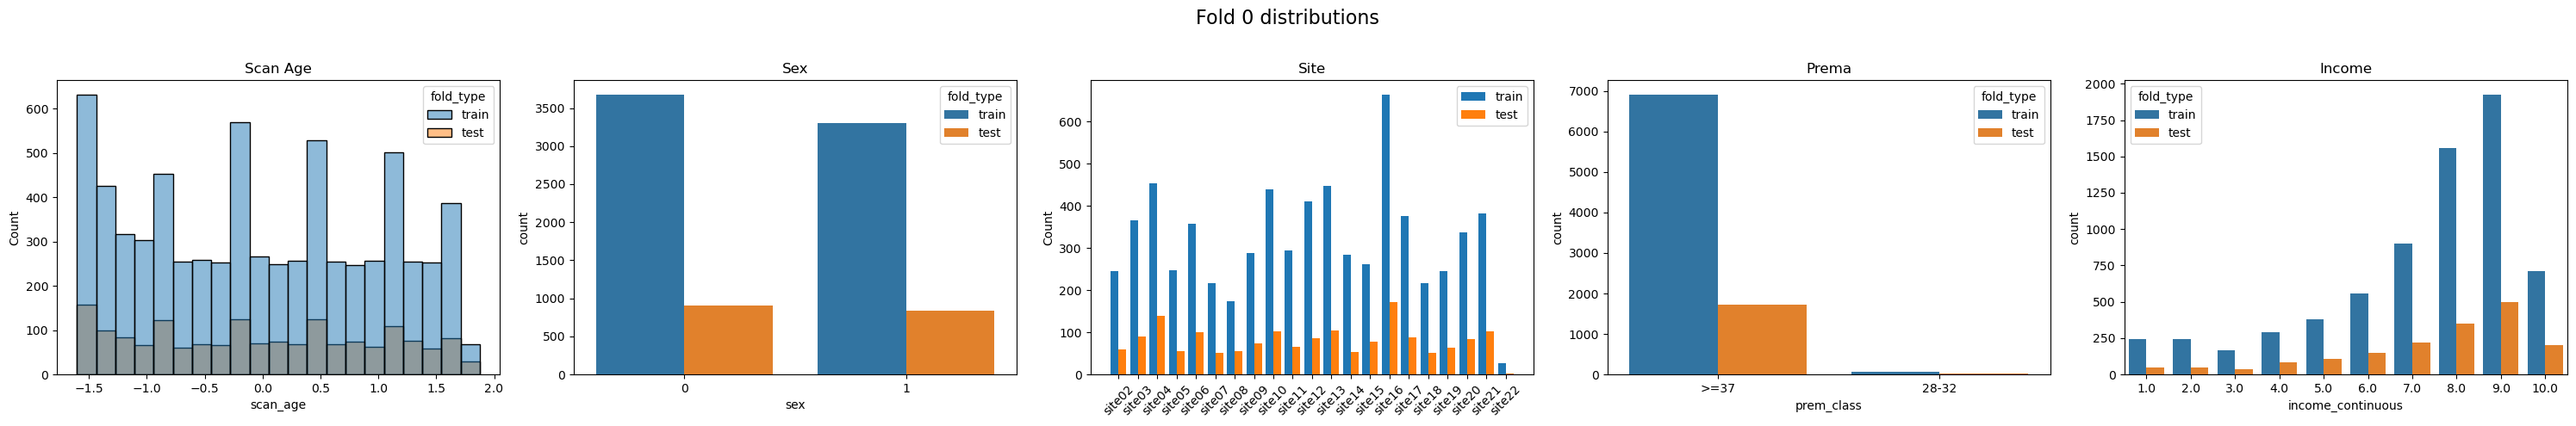

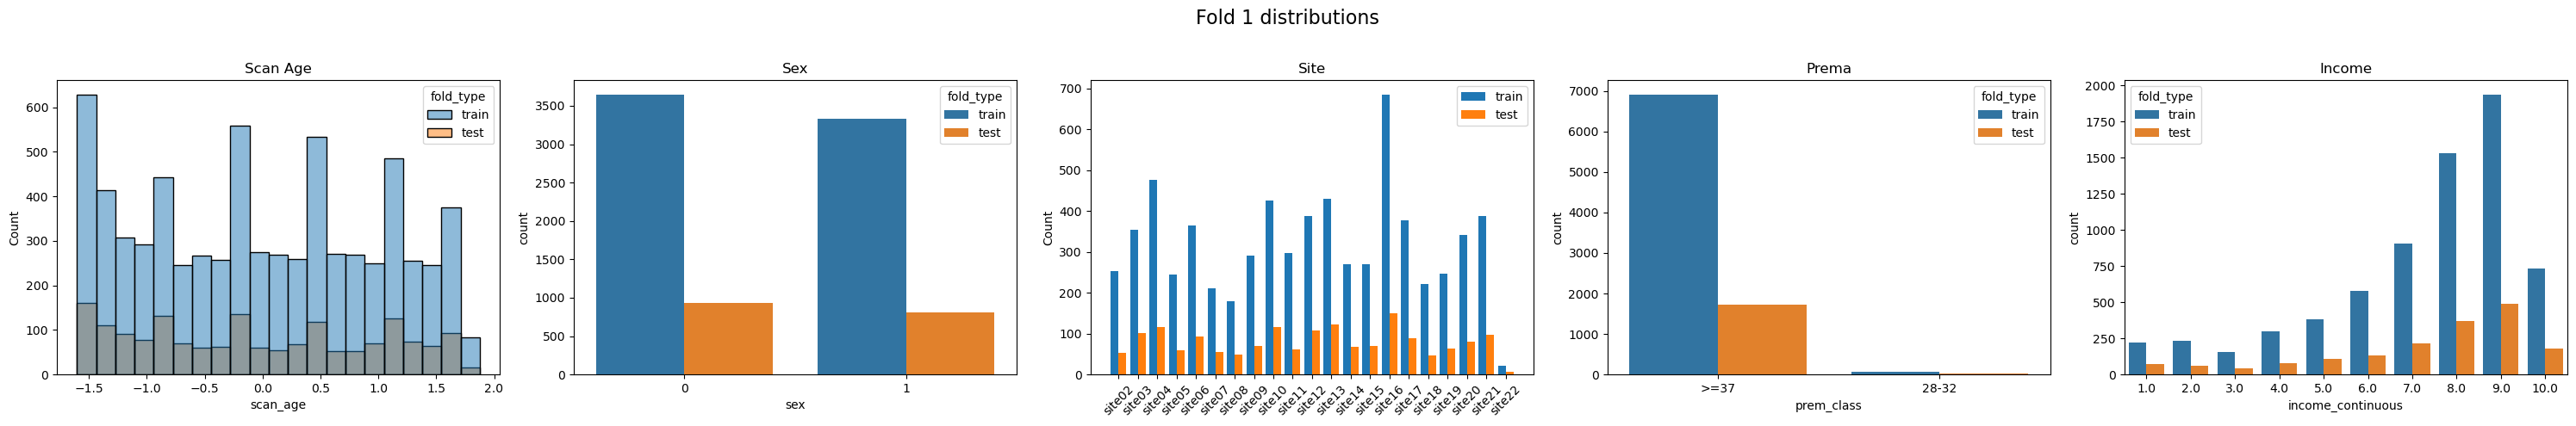

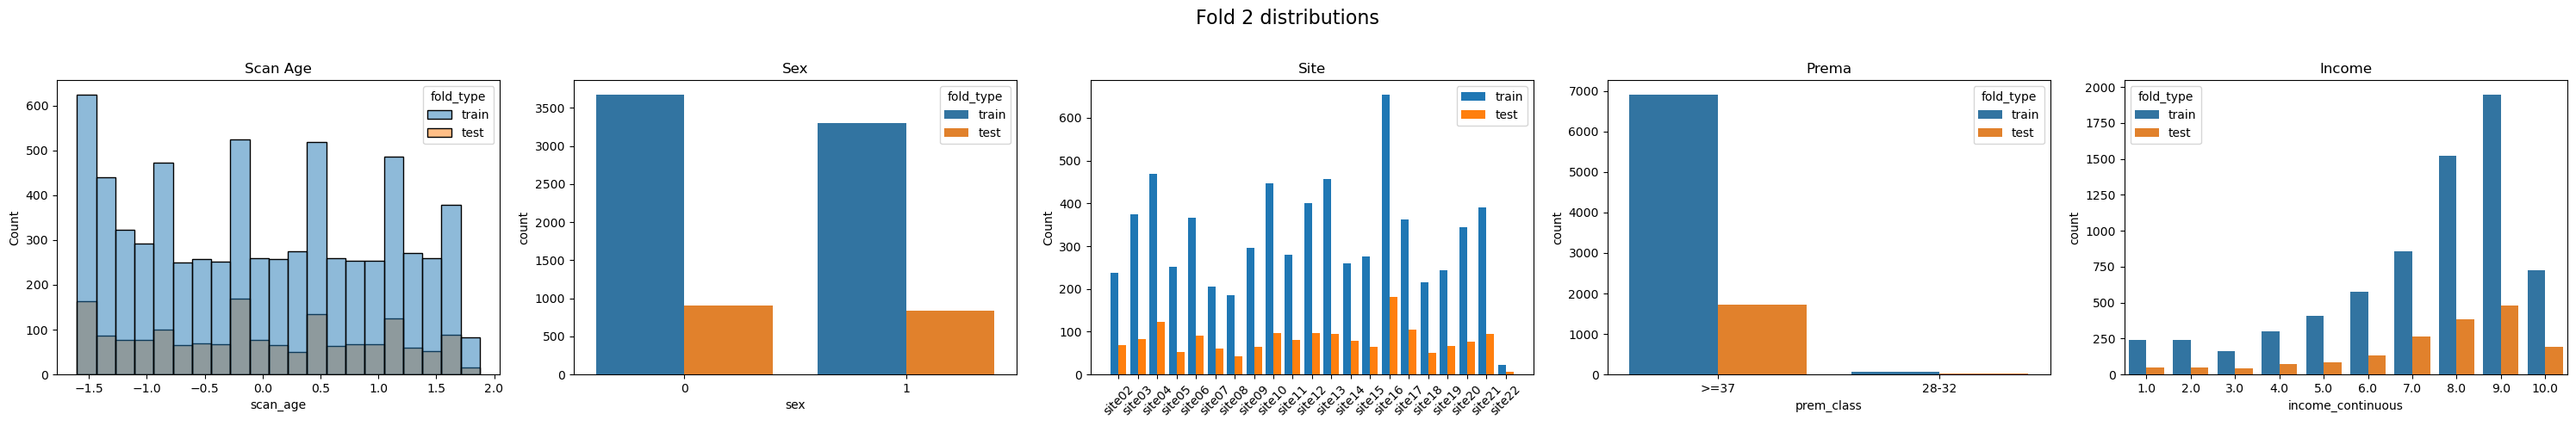

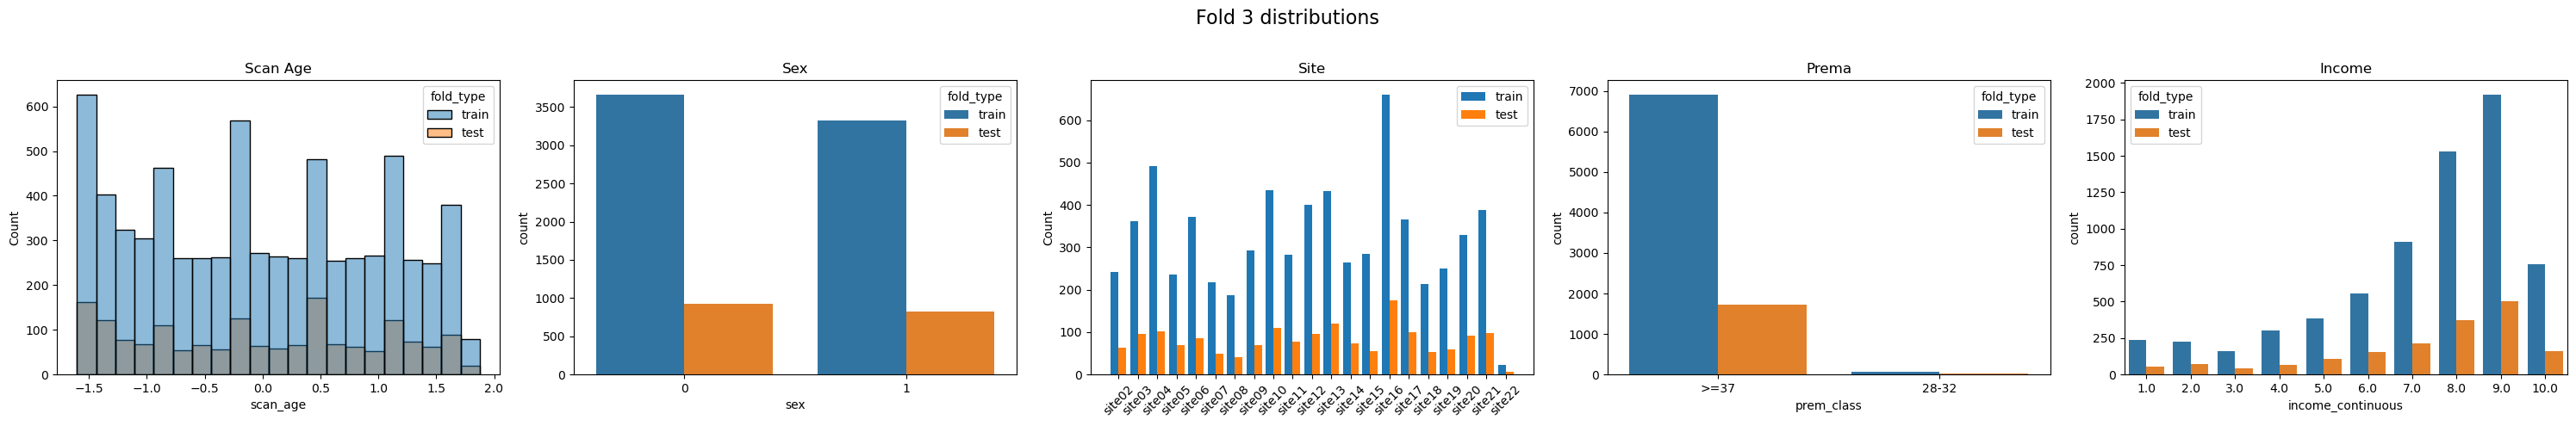

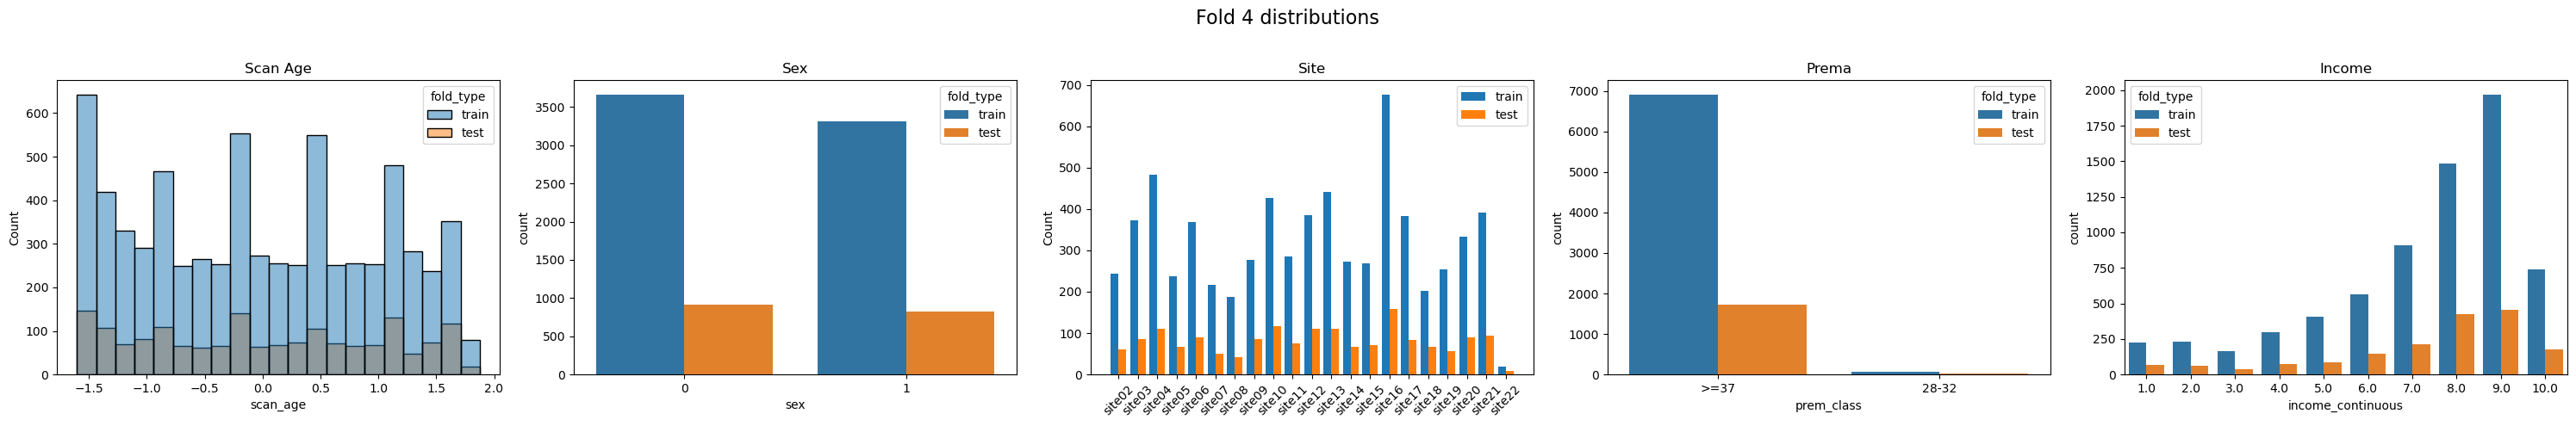

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_fold_distributions(folds_residualized, df_complete, id_label_col='subject_id'):
    """
    Plot distributions of scan_age, sex, site, and prema for each fold, 
    comparing train vs test sets.

    folds_residualized : list of dicts from residualize_in_folds_from_prep()
    df_complete : original dataframe containing scan_age, sex, site, prema, and IDs
    id_label_col : column name in df_complete that contains IDs
    
    """

    for i, fold in enumerate(folds_resids):
        if 'y_train' not in fold:
            continue
        print(f"Fold {i}: train={len(fold['train_ids'])}, test={len(fold['test_ids'])}")

    n_folds = len([f for f in folds_residualized if 'y_train' in f])

    for i, fold in enumerate(folds_residualized):
        if 'y_train' not in fold:
            continue

        train_ids = [str(x) for x in fold['train_ids']]
        test_ids  = [str(x) for x in fold['test_ids']]

        # Build a dataframe with fold_type
        df_train = df_complete[df_complete[id_label_col].astype(str).isin(train_ids)].copy()
        df_train['fold_type'] = 'train'

        df_test = df_complete[df_complete[id_label_col].astype(str).isin(test_ids)].copy()
        df_test['fold_type'] = 'test'

        df_fold = pd.concat([df_train, df_test])

        fig, axes = plt.subplots(1, 5, figsize=(30, 5))
        fig.suptitle(f"Fold {i} distributions", fontsize=16)

        # Scan age
        sns.histplot(data=df_fold, x='scan_age', hue='fold_type', kde=False, ax=axes[0])
        axes[0].set_title("Scan Age")

        # Sex
        sns.countplot(data=df_fold, x='sex', hue='fold_type', ax=axes[1])
        axes[1].set_title("Sex")

        # Site
        site_cols = [f'site{str(j).zfill(2)}' for j in range(2,23)]
        site_counts_train = df_fold[df_fold['fold_type']=='train'][site_cols].sum()
        site_counts_test  = df_fold[df_fold['fold_type']=='test'][site_cols].sum()
        x = np.arange(len(site_cols))
        axes[2].bar(x - 0.2, site_counts_train.values, width=0.4, label='train')
        axes[2].bar(x + 0.2, site_counts_test.values, width=0.4, label='test')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(site_cols, rotation=45)
        axes[2].set_ylabel("Count")
        axes[2].set_title("Site")
        axes[2].legend()

        # Prema
        sns.countplot(data=df_fold, x='prem_class', hue='fold_type', ax=axes[3])
        axes[3].set_title("Prema")

        # Income
        sns.countplot(data=df_fold, x='income_continuous', hue='fold_type', ax=axes[4])
        axes[4].set_title("Income")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()



plot_fold_distributions(folds_resids, preps['df_complete'], id_label_col='src_subject_id')


In [16]:
def get_region_list(json_file_path="/neurospin/dico/data/deep_folding/current/sulci_regions_champollion_V1.json"):
   

    with open(json_file_path, 'r') as f:
        data = json.load(f)["brain"]


    def extract_keys(d, sep='_'):
        keys = []
        for k, v in d.items():
            new_key = k
            keys.append(new_key)

        return keys
    
    # Remove all the "." in the keys
    region_list = extract_keys(data)
    region_list = [region.replace('.','') for region in region_list]

    return region_list

region_list = get_region_list()
print("region_list :",region_list)
print(len(region_list))

    

region_list : ['SC-sylv_left', 'SC-SPeC_left', 'SC-SPoC_left', 'SPeC_left', 'SPoC_left', 'SFint-FCMant_left', 'SFinf-BROCA-SPeCinf_left', 'STs_left', 'ScCal-SLi_left', 'FCMpost-SpC_left', 'STi-SOTlat_left', 'OCCIPITAL_left', 'FIP-FIPPoCinf_left', 'SFinter-SFsup_left', 'SFmedian-SFpoltr-SFsup_left', 'SOr_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SsP-SPaint_left', 'STsbr_left', 'Lobule_parietal_sup_left', 'SFmarginal-SFinfant_left', 'FColl-SRh_left', 'STi-STs-STpol_left', 'FCLp-subsc-FCLa-INSULA_left', 'SFint-SR_left', 'SCall_left', 'SCall-SsP-SintraCing_left', 'SC-sylv_right', 'SC-SPeC_right', 'SC-SPoC_right', 'SPeC_right', 'SPoC_right', 'SFint-FCMant_right', 'SFinf-BROCA-SPeCinf_right', 'STs_right', 'ScCal-SLi_right', 'FCMpost-SpC_right', 'STi-SOTlat_right', 'OCCIPITAL_right', 'FIP-FIPPoCinf_right', 'SFinter-SFsup_right', 'SFmedian-SFpoltr-SFsup_right', 'SOr_right', 'SOr-SOlf_right', 'FPO-SCu-ScCal_right', 'SsP-SPaint_right', 'STsbr_right', 'Lobule_parietal_sup_right', 'SFmarginal

In [ ]:
def process_combo(region, threshold, n_jobs=1, n_permutations=11200):
    """Process a single (region, threshold) combo."""
    start_time = perf_counter()

    # embeddings
    embeddings_df = load_embeddings(region)

    # confounds
    confounds_df = set_confound_df()

    # prepare CV data
    preps = prepare_cv_data(embeddings_df, labels_df, confounds_df, threshold=threshold)

    # residualization
    folds_resids = residualize_in_folds_from_prep_combat_final(preps)

    # classification
    results = classify_with_resid(
        folds_resids,
        n_jobs=n_jobs,
        n_permutations=n_permutations,
    )

    # retourner un dict compatible avec le CSV
    duration_min = (perf_counter() - start_time) / 60.0
    out_dict = {
        'region': region,
        'threshold': threshold,
        'auc_per_fold': results['auc_per_fold'],
        'auc_mean': results['auc_mean'],
        'auc_std': results['auc_std'],
        'auc_oof': results['auc_oof'],
        'fixed_C': results['fixed_C'],
        'perm_scores': results['perm_scores'],
        'perm_pvalue': results['perm_pvalue'],
        'ci95_null': results['ci95_null'],
        'auc_threshold_at_alpha': results['auc_threshold_at_alpha'],
        'n_permutations_effective': results['n_permutations_effective'],
        'final_estimator': results['final_estimator'],
        'final_coef_original': results['final_coef_original'],
        'final_intercept_original': results['final_intercept_original'],
        'duration_min': duration_min,
    }
    return out_dict


# Gestion checkpoint
if os.path.exists(output_csv):
    done_df = pd.read_csv(output_csv)
    done_set = set(zip(done_df['region'], done_df['threshold']))
else:
    done_set = set()

# Combinaisons à tester
combos = [(r, t) for r in region_list for t in thresholds]
pending_combos = [(r, t) for r, t in combos if (r, t) not in done_set]

print(f"Total combos: {len(combos)}, déjà faits: {len(done_set)}, à calculer: {len(pending_combos)}")

# Paramètres de parallélisation
n_jobs_outer = 3   # processus externes
n_jobs_inner = 28  # pour GridSearch / permutation interne

# Ouvre en append si fichier existe, sinon création + header
file_exists = os.path.exists(output_csv)
with open(output_csv, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=[
        'region', 'threshold',
        'auc_per_fold', 'auc_mean', 'auc_std', 'auc_oof',
        'fixed_C',
        'perm_scores', 'perm_pvalue', 'ci95_null',
        'auc_threshold_at_alpha',
        'final_estimator', 'final_coef_original', 'final_intercept_original',
        'n_permutations_effective', 'duration_min'
    ])
    if not file_exists:
        writer.writeheader()

    with ProcessPoolExecutor(max_workers=n_jobs_outer) as exe:
        futures = {
            exe.submit(process_combo, r, t, n_jobs_inner, 11200): (r, t)
            for r, t in pending_combos
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc="Blocs traités"):
            try:
                res = future.result()
                writer.writerow(res)
                f.flush()
            except Exception as e:
                r, t = futures[future]
                print(f"Erreur pour combo ({r},{t}): {e}")



In [9]:
# Charger le fichier CSV d'origine
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/03_main/Output/csv/ABCD_prematurity_results_0708.csv')

# Remplacer les AUC_mean non significatifs (p_value >= 0.05) par 0
df.loc[df['perm_pvalue'] >= 0.005, 'cv_auc_mean'] = 0.0

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='threshold', values='cv_auc_mean')

# Renommer les colonnes
df_pivot = df_pivot.rename(columns={
    '28-32': 'AUC_28_32',
    '32-37': 'AUC_37'
}).reset_index()

# Exporter le résultat
output_csv = '/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_0708_thresholded.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")

Fichier généré : /neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_0708_thresholded.csv


In [10]:
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_prematurity_results.csv")

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='threshold', values='cv_auc_mean')

# Renommer les colonnes pour clarifier
df_pivot = df_pivot.rename(columns={
    '<27': 'AUC_27',
    '27-32': 'AUC_27_32',
    '32-37': 'AUC_32_37'
}).reset_index()

# Sauvegarder le nouveau CSV
output_csv = '/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_2406.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")



Fichier généré : /neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_2406.csv
